In [36]:
%load_ext autoreload
%autoreload 2
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_raw = load_dataframe()

In [3]:
df_raw.head()

,text,label
0,US trade gap ballooned in October\n\nThe US tr...,business
1,Japanese mogul arrested for fraud\n\nOne of Ja...,business
2,Jarvis sells Tube stake to Spain\n\nShares in ...,business
3,Small firms 'hit by rising costs'\n\nRising fu...,business
4,Oil prices fall back from highs\n\nOil prices ...,business


In [4]:
PREPROCESSING_PIPELINE = [
                        lower,
                        remove_emails,
                        replace_special_characters,
                        replace_br,
                        filter_out_uncommon_symbols,
                        remove_stopwords,
                        strip_text
                    ]

In [5]:
print('Pre-processing text...')
 
print()
print(f'[Debug] Before:\n{df_raw.text.values[0]}')
print()
 
# Replace each sentence with its pre-processed version
df = df_raw.copy()
df['text'] = df_raw['text'].apply(lambda txt: text_prepare(txt, PREPROCESSING_PIPELINE))

print(f'[Debug] After:\n{df.text.values[0]}')
print()
 
print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
US trade gap ballooned in October

The US trade deficit widened by more than expected in October, hitting record levels after higher oil prices raised import costs, figures have shown

The trade shortfall was $55.5bn (£29bn), up 9% from September, the Commerce Department said. That pushed the 10 month deficit to $500.5bn. Imports rose by 3.4%, while exports increased by only 0.6%. A weaker dollar also increased the cost of imports, though this should help drive export demand in coming months. "Things are getting worse, but that's to be expected," said David Wyss of Standard & Poor's in New York. "The first thing is that when the dollar goes down, it increases the price of imports. "We are seeing improved export orders. Things seem to be going in the right direction."

Despite this optimism, significant concerns remain as to how the US will fund its trade and budget deficits should they continue to widen. Another problem highlighted by analysts wa

In [6]:
# drop from df rows where text number of words are less than 50
df = df[df['text'].apply(lambda x: len(x.split()) > 100)]

In [7]:
path = 'vocab/'
if not os.path.exists(path):
    os.makedirs(path)

# Check if vocabulary has already been built
vocab_regex = re.compile(r'idx_to_word\.pkl|word_to_idx\.pkl|word_listing\.pkl')

if len(os.listdir(path)) > 0 and all([vocab_regex.search(f) for f in os.listdir(path)]):
    print('Loading existing vocabulary...')
    idx_to_word, word_to_idx, word_listing = load_vocab()
    print('Vocabulary loaded!')
else:
    print('Building vocabulary...')
    idx_to_word, word_to_idx, word_listing = build_vocabulary(df)
    print('Saving vocabulary...')
    save_vocab(idx_to_word, word_to_idx, word_listing)
    print('Vocabulary built!')

Loading existing vocabulary...
Vocabulary loaded!


In [8]:
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, df)

[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...


100%|██████████| 31383/31383 [00:00<00:00, 523412.39it/s]


[Vocabulary Evaluation] Consistency checking...


100%|██████████| 783/783 [00:00<00:00, 4406.04it/s]


[Vocabulary Evaluation] Toy example checking...


100%|██████████| 2/2 [00:00<00:00, 3889.02it/s]


In [9]:
corpus_len = df['text'].apply(lambda x: len(x.split(' '))).values
max_nodes_in_graph = np.min(corpus_len)

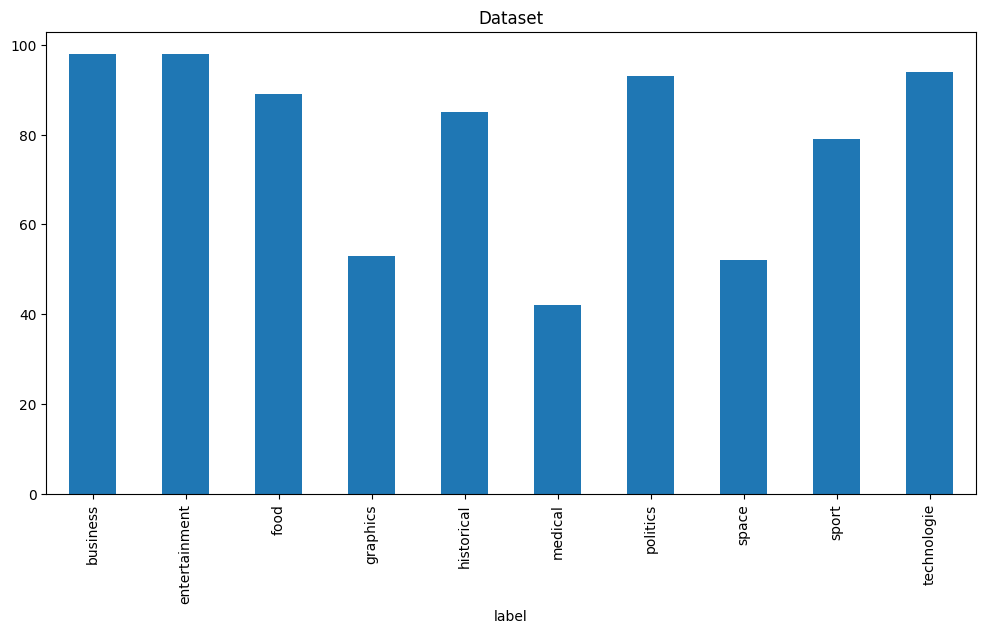

In [10]:
plot_label_distribution([df], labels=['Dataset'])

## PMI

In [11]:
text_tests = df['text'].values
PMIs = []
W2Is = []
I2Ws = []
for text in text_tests:
    PMI, WTI, ITW = compute_pmi(text)
    PMIs.append(PMI)
    W2Is.append(WTI)
    I2Ws.append(ITW)

In [12]:
PMIs_thr = []
for pmi in PMIs:
    threshold = compute_threshold(pmi)
    PMIs_thr.append(threshold_pmi(pmi, threshold))

In [13]:
centrality_measure = 'degree'
PMIs_centrality = [compute_centrality(pmi, centrality_measure) for pmi in PMIs_thr]
# sort by centrality
PMIs_centrality = [sorted(pmi.items(), key=lambda x: x[1], reverse=True) for pmi in PMIs_centrality]

# get top max_node_in_graph words
PMIs_centrality = [pmi[:max_nodes_in_graph] for pmi in PMIs_centrality]

In [14]:
import sklearn
from sklearn import cluster

# Construct a similarity matrix from the PMI matrices
similarity_matrix = np.zeros((len(PMIs), len(PMIs)))
for i in range(len(PMIs)):
  for j in range(len(PMIs)):
    pmi_to_check = [PMIs[i], PMIs[j]]
    pmi_centrality_to_check = [get_index_from_measure_matrix(PMIs_centrality[i]), get_index_from_measure_matrix(PMIs_centrality[j])]
    i2w_to_check = [I2Ws[i], I2Ws[j]]
    w2i_to_check = [W2Is[i], W2Is[j]]
    similarity_matrix[i, j] = compute_similarity_score(pmi_to_check, pmi_centrality_to_check, i2w_to_check, w2i_to_check)


# print(similarity_matrix)
# Choose a clustering algorithm
kmeans = sklearn.cluster.KMeans(n_clusters=10)

# Apply the clustering algorithm to the similarity matrix
cluster_labels = kmeans.fit_predict(similarity_matrix)

In [15]:
def assign_classes_to_clusters_with_highest_number_of_elements(kmeans_labels, ground_truth_labels):  
    cluster_to_class_counts = {}
    for i in range(len(kmeans_labels)):
        cluster_label = kmeans_labels[i]
        ground_truth_label = ground_truth_labels[i]
        if cluster_label not in cluster_to_class_counts:
            cluster_to_class_counts[cluster_label] = {}
        if ground_truth_label not in cluster_to_class_counts[cluster_label]:
            cluster_to_class_counts[cluster_label][ground_truth_label] = 0
        cluster_to_class_counts[cluster_label][ground_truth_label] += 1
    cluster_to_class_labels = {}
    for cluster_label in cluster_to_class_counts:
        max_count_class_label = max(cluster_to_class_counts[cluster_label].items(), key=lambda item: item[1])[0]
        cluster_to_class_labels[cluster_label] = max_count_class_label   
    return cluster_to_class_labels

In [16]:
kmeans_labels = cluster_labels
ground_truth_labels = df['label'].values
cluster_to_class_labels = assign_classes_to_clusters_with_highest_number_of_elements(kmeans_labels, ground_truth_labels)
accuracy = np.mean([cluster_to_class_labels[kmeans_labels[i]] == ground_truth_labels[i] for i in range(len(kmeans_labels))])
print('Accuracy:', accuracy)

Accuracy: 0.611749680715198


### Relationship between the most influential words and the cluster to which they are assigned

In [17]:
# get the top k words for each text 
words_clusters = {}
k = 3
for i in range(len(PMIs_centrality)):
    pmi = PMIs_centrality[i]
    i2w = I2Ws[i]
    
    top_k = pmi[:k]    
    idxs = [idx for idx, _ in top_k]
    words = [i2w[idx] for idx in idxs]
    
    # get the original label for each text
    labels = df['label'].values
    words_clusters[i] = (words, labels[i])

print(words_clusters)

{0: (['dollar', 'imports', 'increased'], 'business'), 1: (['business', 'tsutsumi', 'made'], 'business'), 2: (['said', 'stake', 'lines'], 'business'), 3: (['cbi', 'firms', 'plus'], 'business'), 4: (['opec', 'us', 'prices'], 'business'), 5: (['former', 'att', 'october'], 'business'), 6: (['year', 'sales', 'profits'], 'business'), 7: (['fiat', 'part', 'car'], 'business'), 8: (['ms', 'prices', 'paulsmeier'], 'business'), 9: (['generic', 'sandoz', 'said'], 'business'), 10: (['charges', 'court', 'khodorkovsky'], 'business'), 11: (['schemes', 'contributions', 'ids'], 'business'), 12: (['braking', 'recall', 'car'], 'business'), 13: (['said', 'new', 'mines'], 'business'), 14: (['carnivals', 'much', 'po'], 'business'), 15: (['japan', 'yen', 'year'], 'business'), 16: (['2004', 'claims', 'around'], 'business'), 17: (['euros', 'sales', 'profits'], 'business'), 18: (['sales', 'said', 'people'], 'business'), 19: (['tax', 'yuan', 'said'], 'business'), 20: (['growth', 'public', 'demand'], 'business'), 

In [18]:
# For each text, get the cluster label
text_to_cluster_label = {}
for i in range(len(text_tests)):
    text_to_cluster_label[i] = cluster_to_class_labels[kmeans_labels[i]]
    words, original_cluster = words_clusters[i]
    # add in the dictionary the label predicted by the clustering algorithm
    # words_clusters --> i : (top_k_words, original_cluster, predicted_cluster)
    words_clusters[i] = (words, original_cluster, text_to_cluster_label[i])
    
print(words_clusters)    

{0: (['dollar', 'imports', 'increased'], 'business', 'business'), 1: (['business', 'tsutsumi', 'made'], 'business', 'business'), 2: (['said', 'stake', 'lines'], 'business', 'technologie'), 3: (['cbi', 'firms', 'plus'], 'business', 'business'), 4: (['opec', 'us', 'prices'], 'business', 'entertainment'), 5: (['former', 'att', 'october'], 'business', 'business'), 6: (['year', 'sales', 'profits'], 'business', 'business'), 7: (['fiat', 'part', 'car'], 'business', 'business'), 8: (['ms', 'prices', 'paulsmeier'], 'business', 'business'), 9: (['generic', 'sandoz', 'said'], 'business', 'technologie'), 10: (['charges', 'court', 'khodorkovsky'], 'business', 'business'), 11: (['schemes', 'contributions', 'ids'], 'business', 'technologie'), 12: (['braking', 'recall', 'car'], 'business', 'business'), 13: (['said', 'new', 'mines'], 'business', 'politics'), 14: (['carnivals', 'much', 'po'], 'business', 'entertainment'), 15: (['japan', 'yen', 'year'], 'business', 'business'), 16: (['2004', 'claims', 'a

In [19]:
# Check if words predicted as the same cluster share the same top_k words
words_in_same_cluster = {}
for i in range(len(words_clusters)):
    words, original_cluster, predicted_cluster = words_clusters[i]
    if predicted_cluster not in words_in_same_cluster:
        words_in_same_cluster[predicted_cluster] = []
    words_in_same_cluster[predicted_cluster].append(words)
print(words_in_same_cluster)

{'business': [['dollar', 'imports', 'increased'], ['business', 'tsutsumi', 'made'], ['cbi', 'firms', 'plus'], ['former', 'att', 'october'], ['year', 'sales', 'profits'], ['fiat', 'part', 'car'], ['ms', 'prices', 'paulsmeier'], ['charges', 'court', 'khodorkovsky'], ['braking', 'recall', 'car'], ['japan', 'yen', 'year'], ['2004', 'claims', 'around'], ['tax', 'yuan', 'said'], ['growth', 'public', 'demand'], ['gms', 'cadillac', 'saabs'], ['costs', 'unemployment', 'data'], ['sales', 'financial', 'japanese'], ['exports', 'quarter', 'recovery'], ['winter', 'us', 'said'], ['china', 'could', 'economy'], ['currency', 'said', 'new'], ['inflation', 'decision', 'rates'], ['crude', 'said', 'weather'], ['sales', 'brands', '2004'], ['newspaper', 'independent', 'group'], ['us', 'sec', 'firms'], ['sales', 'economic', 'consumer'], ['january', 'growth', 'rise'], ['spending', '2006', 'niesr'], ['merrills', 'ms', 'claim'], ['districts', 'higher', 'also'], ['growth', 'oecd', 'oil'], ['women', 'saudi', 'year'

In [20]:
from collections import Counter

# Check which are the most common words in each cluster
most_common_words_in_cluster = {}
for cluster in words_in_same_cluster:
    words = words_in_same_cluster[cluster]
    words = [word for sublist in words for word in sublist]
    most_common_words_in_cluster[cluster] = Counter(words).most_common(10)
print(most_common_words_in_cluster)


{'business': [('said', 14), ('year', 13), ('sales', 7), ('growth', 7), ('us', 6), ('2004', 5), ('economy', 5), ('race', 4), ('costs', 3), ('january', 3)], 'technologie': [('said', 43), ('people', 16), ('would', 9), ('data', 7), ('software', 6), ('microsoft', 6), ('games', 5), ('search', 5), ('information', 5), ('government', 5)], 'entertainment': [('film', 11), ('festival', 7), ('best', 4), ('said', 4), ('award', 3), ('musical', 3), ('films', 3), ('actress', 2), ('performance', 2), ('daylewis', 2)], 'politics': [('said', 31), ('would', 10), ('mr', 7), ('government', 5), ('labour', 4), ('chancellor', 4), ('lord', 4), ('party', 3), ('schools', 3), ('lords', 3)], 'historical': [('war', 22), ('german', 13), ('french', 11), ('algeria', 5), ('fln', 5), ('military', 5), ('egypt', 5), ('british', 5), ('france', 4), ('ancient', 4)], 'graphics': [('like', 7), ('design', 7), ('food', 6), ('nasa', 6), ('also', 5), ('dont', 5), ('health', 5), ('help', 5), ('get', 4), ('may', 4)], 'food': [('1', 18)

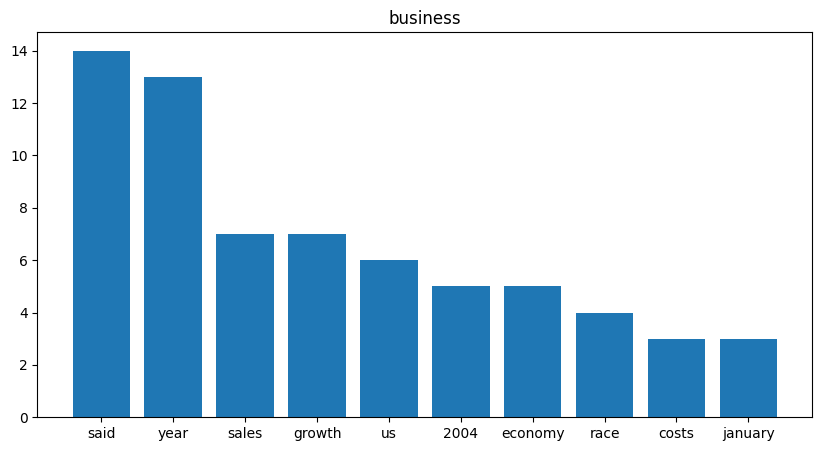

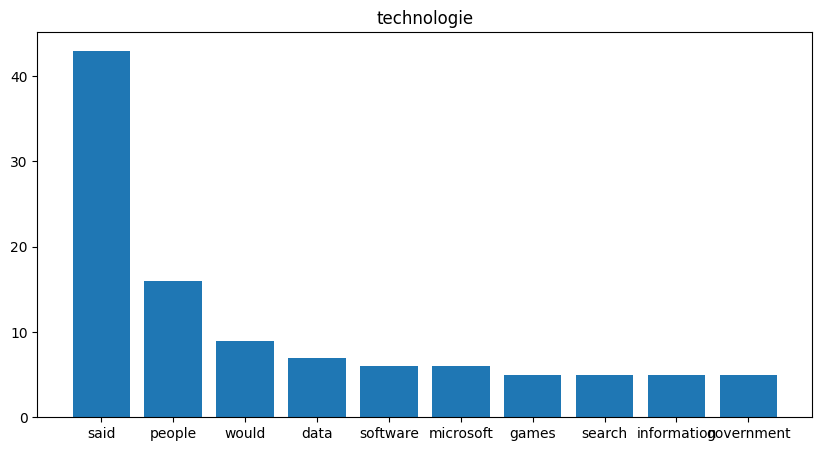

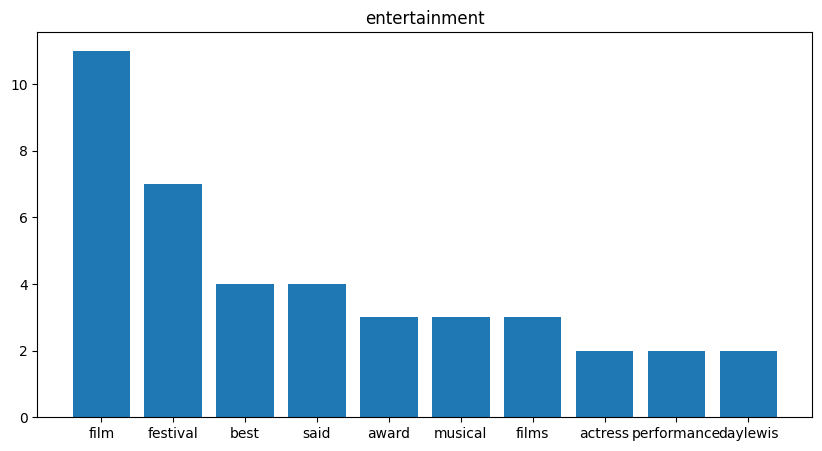

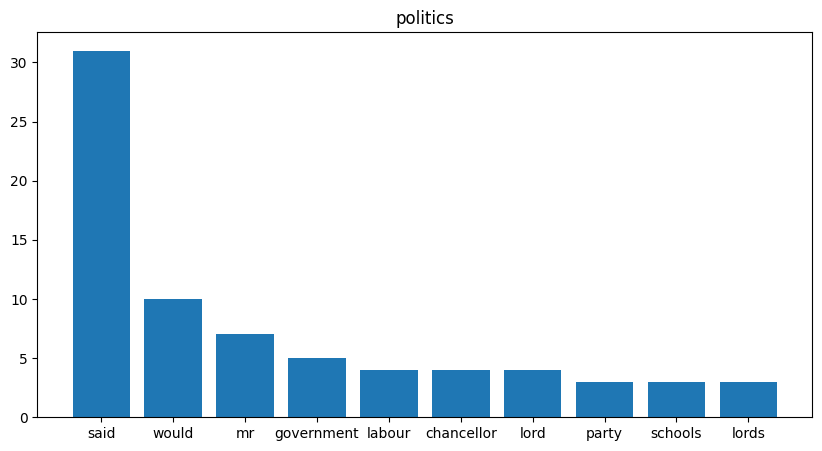

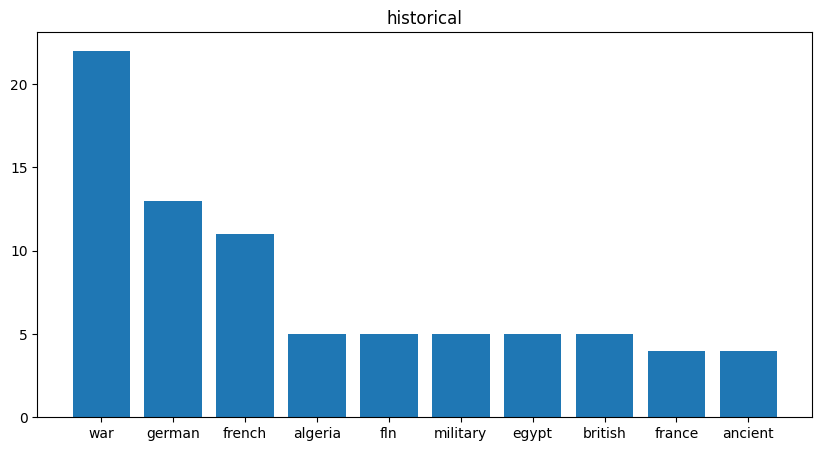

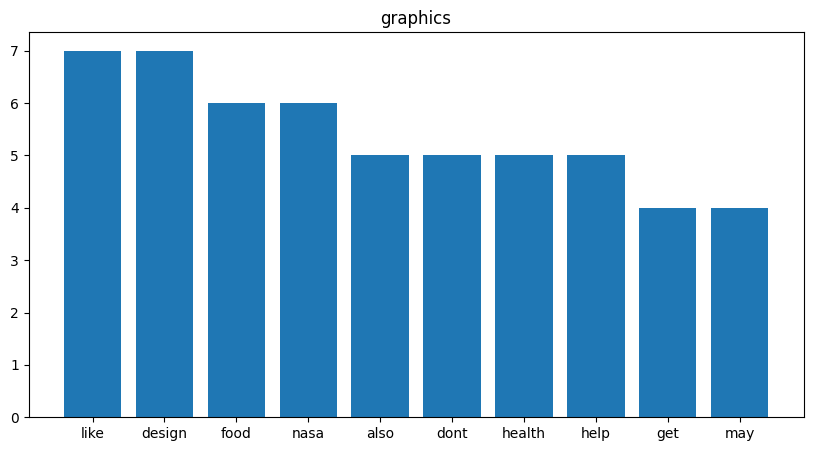

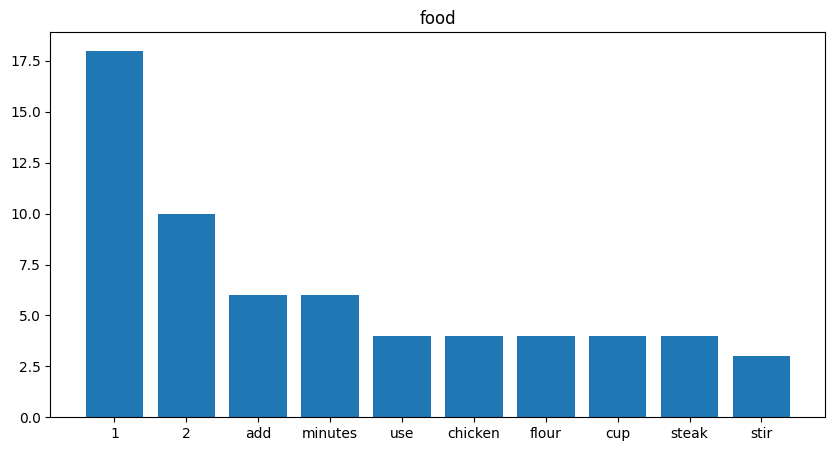

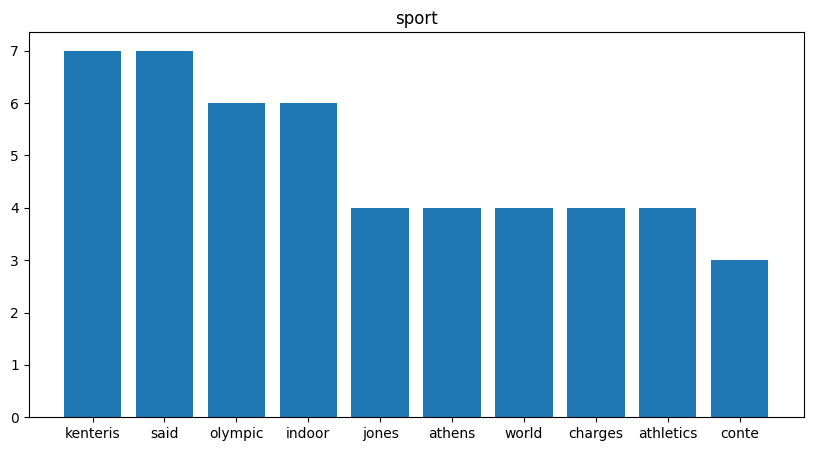

In [21]:
# For each cluster: histogram of the most common words
for cluster in most_common_words_in_cluster:
    words = most_common_words_in_cluster[cluster]
    words = [word for word, _ in words]
    plt.figure(figsize=(10, 5))
    plt.bar(words, [count for _, count in most_common_words_in_cluster[cluster]])
    plt.title(f'{cluster}')
    plt.show()

In [66]:

import random
def compute_structural_equivalence(G1,G2):
    # compute structural equivalence
    structural_equivalence = {}
    for node1 in G1.nodes():
        for node2 in G2.nodes():
            if node1 not in structural_equivalence:
                structural_equivalence[node1] = {}
            if node2 not in structural_equivalence[node1]:
                structural_equivalence[node1][node2] = 0
            if node1 in G2.neighbors(node2):
                if node2 in G1.neighbors(node1):
                    structural_equivalence[node1][node2] = 1
    return structural_equivalence

x = 100

already_done = []
arr = np.zeros(783)
for i in range(x):
    random_number = random.randint(0,783)
    while random_number in already_done:
        random_number = random.randint(0,783)
    arr[random_number] = 1

sub_PMIs = []
sub_W2Is = []
sub_I2Ws = []

for i in range(len(PMIs)):
    if(arr[i] == 1):
        sub_PMIs.append(PMIs_thr[i])
        sub_W2Is.append(W2Is[i])
        sub_I2Ws.append(I2Ws[i])

similarity_matrix = np.zeros((len(sub_PMIs), len(sub_PMIs)))
for i in range(len(sub_PMIs)):
  for j in range(len(sub_PMIs)):
    G1 = get_graph_from_pmi(sub_PMIs[i], sub_I2Ws[i], sub_W2Is[i])
    G2 = get_graph_from_pmi(sub_PMIs[j], sub_I2Ws[j], sub_W2Is[j])
    structural_equivalence = compute_structural_equivalence(G1, G2)
    structural_equivalence_num = 1
    for node1 in structural_equivalence:
        for node2 in structural_equivalence[node1]:
            if structural_equivalence[node1][node2] == 1:
                structural_equivalence_num += 1/(math.sqrt(G1.degree(node1))*math.sqrt(G2.degree(node2)))
    similarity_matrix[i, j] = 1/structural_equivalence_num

kmeans = sklearn.cluster.KMeans(n_clusters=10)

# Apply the clustering algorithm to the similarity matrix
cluster_labels = kmeans.fit_predict(similarity_matrix)

In [67]:
kmeans_labels = cluster_labels
ground_truth_labels = df['label'].values
ground_truth_labels = np.array(ground_truth_labels)
ground_truth_labels = ground_truth_labels[arr==1]
cluster_to_class_labels = assign_classes_to_clusters_with_highest_number_of_elements(kmeans_labels, ground_truth_labels)
accuracy = np.mean([cluster_to_class_labels[kmeans_labels[i]] == ground_truth_labels[i] for i in range(len(kmeans_labels))])
print('Accuracy:', accuracy)

Accuracy: 0.5054945054945055
